# Hệ thống huấn luyện mô hình nhận dạng dấu thanh

Hệ thống sử dụng MediaPipe để nhận dạng 5 dấu thanh: huyền, sắc, hỏi, ngã, nặng thông qua các hành động tay.

## Các bước thực hiện:
1. Import thư viện và khởi tạo
2. Kiểm tra dữ liệu
3. Chuẩn bị dữ liệu
4. Xây dựng mô hình LSTM
5. Xây dựng mô hình CNN
6. Huấn luyện mô hình
7. Đánh giá kết quả

## 1. Import thư viện và khởi tạo

In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from utils.data_utils import DataProcessor

# Thiết lập matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("TensorFlow version:", tf.__version__)
print("NumPy version:", np.__version__)

TensorFlow version: 2.19.0
NumPy version: 1.26.3


## 2. Khởi tạo DataProcessor và kiểm tra dữ liệu

In [16]:
# Khởi tạo DataProcessor
data_processor = DataProcessor()
classes = data_processor.classes
class_names = data_processor.class_names

print("=== THÔNG TIN DỮ LIỆU ===")
print(f"Số lớp: {len(classes)}")
print("Các lớp:", [class_names[cls] for cls in classes])

# Kiểm tra thống kê dữ liệu
stats = data_processor.get_data_statistics()
print(f"\nThống kê dữ liệu:")
for cls in classes:
    print(f"  {class_names[cls]}: {stats[cls]} mẫu")
print(f"Tổng cộng: {stats['total']} mẫu")

if stats['total'] < 50:
    print("\n⚠️  CẢNH BÁO: Dữ liệu quá ít! Cần thu thập thêm dữ liệu.")
else:
    print("\n✅ Dữ liệu đủ để huấn luyện!")

=== THÔNG TIN DỮ LIỆU ===
Số lớp: 5
Các lớp: ['huyen', 'sac', 'hoi', 'nga', 'nang']

Thống kê dữ liệu:
  huyen: 40 mẫu
  sac: 40 mẫu
  hoi: 40 mẫu
  nga: 40 mẫu
  nang: 40 mẫu
Tổng cộng: 200 mẫu

✅ Dữ liệu đủ để huấn luyện!


## 3. Chuẩn bị dữ liệu cho huấn luyện

In [17]:
print("Đang chuẩn bị dữ liệu...")

# Tải dữ liệu
X_train, X_test, y_train, y_test, label_encoder = data_processor.prepare_training_data(
    test_size=0.2
)

# Chia validation từ training
val_size = int(0.2 * len(X_train))
X_val = X_train[-val_size:]
y_val = y_train[-val_size:]
X_train = X_train[:-val_size]
y_train = y_train[:-val_size]

# Cập nhật input shape
input_shape = (X_train.shape[1], X_train.shape[2])
num_classes = len(classes)

print(f"\nShape dữ liệu:")
print(f"  Training: {X_train.shape}")
print(f"  Validation: {X_val.shape}")
print(f"  Test: {X_test.shape}")
print(f"  Input shape: {input_shape}")
print(f"  Số lớp: {num_classes}")

# Hiển thị phân bố dữ liệu
print(f"\nPhân bố dữ liệu training:")
unique, counts = np.unique(y_train, return_counts=True)
for i, (cls_idx, count) in enumerate(zip(unique, counts)):
    cls_name = label_encoder.inverse_transform([cls_idx])[0]
    print(f"  {class_names[cls_name]}: {count} mẫu")

Đang chuẩn bị dữ liệu...

Shape dữ liệu:
  Training: (128, 30, 63)
  Validation: (32, 30, 63)
  Test: (40, 30, 63)
  Input shape: (30, 63)
  Số lớp: 5

Phân bố dữ liệu training:
  hoi: 29 mẫu
  huyen: 28 mẫu
  nang: 24 mẫu
  nga: 23 mẫu
  sac: 24 mẫu


## 4. Xây dựng mô hình LSTM

In [18]:
def build_lstm_model(input_shape, num_classes):
    """Xây dựng mô hình LSTM"""
    model = models.Sequential([
        # LSTM layers
        layers.LSTM(128, return_sequences=True, input_shape=input_shape),
        layers.Dropout(0.3),
        layers.LSTM(64, return_sequences=False),
        layers.Dropout(0.3),
        
        # Dense layers
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Tạo mô hình LSTM
lstm_model = build_lstm_model(input_shape, num_classes)
print("=== MÔ HÌNH LSTM ===")
lstm_model.summary()

=== MÔ HÌNH LSTM ===


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 128)        │        98,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,117 (602.02 KB)

 Trainable params: 154,117 (602.02 KB)

 Non-trainable params: 0 (0.00 B)

## 5. Xây dựng mô hình MLP

In [19]:
def build_mlp_model(input_shape, num_classes):
    """Xây dựng mô hình MLP"""
    model = models.Sequential([
        layers.Flatten(input_shape=input_shape),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Tạo mô hình MLP
mlp_model = build_mlp_model(input_shape, num_classes)
print("=== MÔ HÌNH MLP ===")
mlp_model.summary()

=== MÔ HÌNH MLP ===


c:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 1890)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       484,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 525,573 (2.00 MB)

 Trainable params: 525,573 (2.00 MB)

 Non-trainable params: 0 (0.00 B)

## 6. Huấn luyện mô hình LSTM

In [20]:
# Thiết lập callbacks cho LSTM
lstm_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7
    ),
    callbacks.ModelCheckpoint(
        filepath='trained_models/lstm_model_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Huấn luyện mô hình LSTM
print("=== HUẤN LUYỆN MÔ HÌNH LSTM ===")
lstm_history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=lstm_callbacks,
    verbose=1
)

=== HUẤN LUYỆN MÔ HÌNH LSTM ===
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2070 - loss: 1.6128
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to trained_models/lstm_model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 194ms/step - accuracy: 0.2000 - loss: 1.6154 - val_accuracy: 0.1250 - val_loss: 1.6297 - learning_rate: 0.0010
Epoch 2/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2847 - loss: 1.5978
Epoch 2: val_accuracy did not improve from 0.12500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2677 - loss: 1.6014 - val_accuracy: 0.1250 - val_loss: 1.6212 - learning_rate: 0.0010
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2240 - loss: 1.6102
Epoch 3: val_accuracy did not improve from 0.12500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2260 - loss: 1.6101 - val_accuracy: 0.1250 - val_loss: 1.6147 - learning_rate: 0.0010
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1309 - loss: 1.6086
Epoch 4: val_accuracy did not improve from 0.12500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1375 - loss: 1.6081 - val_accuracy: 0.0938 - val_loss: 1.6122 - learning_rate: 0.0010
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.2656 - loss: 1.5632 - val_accuracy: 0.1875 - val_loss: 1.5565 - learning_rate: 0.0010
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2734 - loss: 1.5561
Epoch 10: val_accuracy did not improve from 0.18750
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2750 - loss: 1.5532 - val_accuracy: 0.0938 - val_loss: 1.5569 - learning_rate: 0.0010
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3561 - loss: 1.4957
Epoch 11: val_accuracy did not improve from 0.18750
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3521 - loss: 1.4936 - val_accuracy: 0.1875 - val_loss: 1.4160 - learning_rate: 0.0010
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3092 - loss: 1.4279
Epoch 12: val_accuracy improved from 0.18750 to 0.40625, saving model to trained_models/lstm_model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.3146 - loss: 1.4283 - val_accuracy: 0.4062 - val_loss: 1.2652 - learning_rate: 0.0010
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3835 - loss: 1.3490
Epoch 13: val_accuracy did not improve from 0.40625
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3740 - loss: 1.3505 - val_accuracy: 0.4062 - val_loss: 1.2092 - learning_rate: 0.0010
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4401 - loss: 1.2999
Epoch 14: val_accuracy improved from 0.40625 to 0.53125, saving model to trained_models/lstm_model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4458 - loss: 1.2919 - val_accuracy: 0.5312 - val_loss: 1.1141 - learning_rate: 0.0010
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4987 - loss: 1.1696
Epoch 15: val_accuracy did not improve from 0.53125
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4958 - loss: 1.1728 - val_accuracy: 0.5312 - val_loss: 1.0548 - learning_rate: 0.0010
Epoch 16/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5260 - loss: 1.0995
Epoch 16: val_accuracy did not improve from 0.53125
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5208 - loss: 1.0992 - val_accuracy: 0.5312 - val_loss: 1.0248 - learning_rate: 0.0010
Epoch 17/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4017 - loss: 1.3068
Epoch 17: val_accuracy did not improve from 0.53125
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3979 - loss: 1.3283 - val_accuracy: 0.4375 - val_loss: 1.6929 - learning_rate: 0.0010
Epoch 18/100
4/4 ━━━━━━━━━━━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5385 - loss: 1.2814 - val_accuracy: 0.7812 - val_loss: 0.9603 - learning_rate: 0.0010
Epoch 19/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4727 - loss: 1.0475
Epoch 19: val_accuracy did not improve from 0.78125
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4750 - loss: 1.0433 - val_accuracy: 0.5938 - val_loss: 0.9693 - learning_rate: 0.0010
Epoch 20/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5560 - loss: 0.9755
Epoch 20: val_accuracy improved from 0.78125 to 0.87500, saving model to trained_models/lstm_model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.5635 - loss: 0.9653 - val_accuracy: 0.8750 - val_loss: 0.7795 - learning_rate: 0.0010
Epoch 21/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6701 - loss: 0.8653 
Epoch 21: val_accuracy did not improve from 0.87500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.6427 - loss: 0.8698 - val_accuracy: 0.7500 - val_loss: 0.7032 - learning_rate: 0.0010
Epoch 22/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5816 - loss: 0.8800
Epoch 22: val_accuracy did not improve from 0.87500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5896 - loss: 0.8772 - val_accuracy: 0.8125 - val_loss: 0.6315 - learning_rate: 0.0010
Epoch 23/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6719 - loss: 0.7794
Epoch 23: val_accuracy did not improve from 0.87500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6750 - loss: 0.7725 - val_accuracy: 0.8125 - val_loss: 0.6339 - learning_rate: 0.0010
Epoch 24/100
4/4 ━━━━━━━━━━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6479 - loss: 0.7636 - val_accuracy: 0.9688 - val_loss: 0.4572 - learning_rate: 0.0010
Epoch 25/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7786 - loss: 0.5738
Epoch 25: val_accuracy did not improve from 0.96875
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.7792 - loss: 0.5733 - val_accuracy: 0.9688 - val_loss: 0.3811 - learning_rate: 0.0010
Epoch 26/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8438 - loss: 0.5590
Epoch 26: val_accuracy did not improve from 0.96875
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8188 - loss: 0.5637 - val_accuracy: 0.9375 - val_loss: 0.3168 - learning_rate: 0.0010
Epoch 27/100
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7587 - loss: 0.4810
Epoch 27: val_accuracy did not improve from 0.96875
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7771 - loss: 0.4735 - val_accuracy: 0.9688 - val_loss: 0.2496 - learning_rate: 0.0010
Epoch 28/100
4/4 ━━━━━━━━━━━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.8365 - loss: 0.4481 - val_accuracy: 1.0000 - val_loss: 0.1149 - learning_rate: 0.0010
Epoch 39/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8620 - loss: 0.4153
Epoch 39: val_accuracy did not improve from 1.00000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8677 - loss: 0.4045 - val_accuracy: 0.9375 - val_loss: 0.1893 - learning_rate: 0.0010
Epoch 40/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9362 - loss: 0.2656
Epoch 40: val_accuracy did not improve from 1.00000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.9333 - loss: 0.2666 - val_accuracy: 1.0000 - val_loss: 0.1530 - learning_rate: 0.0010
Epoch 41/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9362 - loss: 0.2902
Epoch 41: val_accuracy did not improve from 1.00000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.9365 - loss: 0.2868 - val_accuracy: 1.0000 - val_loss: 0.0647 - learning_rate: 0.0010
Epoch 42/100
4/4 ━━━━━━━━━━━━━━━━━━━━

## 7. Huấn luyện mô hình MLP

In [21]:
# Thiết lập callbacks cho MLP
mlp_callbacks = [
    callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-7
    ),
    callbacks.ModelCheckpoint(
        filepath='trained_models/mlp_model_best.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Huấn luyện mô hình MLP
print("=== HUẤN LUYỆN MÔ HÌNH MLP ===")
mlp_history = mlp_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=mlp_callbacks,
    verbose=1
)

=== HUẤN LUYỆN MÔ HÌNH MLP ===
Epoch 1/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.2188 - loss: 1.9678
Epoch 1: val_accuracy improved from -inf to 0.09375, saving model to trained_models/mlp_model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.2156 - loss: 1.8201 - val_accuracy: 0.0938 - val_loss: 1.7267 - learning_rate: 0.0010
Epoch 2/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3438 - loss: 1.5339
Epoch 2: val_accuracy improved from 0.09375 to 0.25000, saving model to trained_models/mlp_model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2708 - loss: 1.7283 - val_accuracy: 0.2500 - val_loss: 1.5723 - learning_rate: 0.0010
Epoch 3/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1250 - loss: 1.9384
Epoch 3: val_accuracy did not improve from 0.25000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1917 - loss: 1.8133 - val_accuracy: 0.2500 - val_loss: 1.5750 - learning_rate: 0.0010
Epoch 4/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2812 - loss: 1.6059
Epoch 4: val_accuracy did not improve from 0.25000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2219 - loss: 1.6918 - val_accuracy: 0.2500 - val_loss: 1.5888 - learning_rate: 0.0010
Epoch 5/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2500 - loss: 1.6481
Epoch 5: val_accuracy improved from 0.25000 to 0.53125, saving model to trained_models/mlp_model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2271 - loss: 1.6635 - val_accuracy: 0.5312 - val_loss: 1.5573 - learning_rate: 0.0010
Epoch 6/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2500 - loss: 1.6525
Epoch 6: val_accuracy did not improve from 0.53125
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2208 - loss: 1.6599 - val_accuracy: 0.2500 - val_loss: 1.5565 - learning_rate: 0.0010
Epoch 7/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3125 - loss: 1.5646
Epoch 7: val_accuracy did not improve from 0.53125
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2990 - loss: 1.5817 - val_accuracy: 0.1250 - val_loss: 1.5482 - learning_rate: 0.0010
Epoch 8/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2500 - loss: 1.5609
Epoch 8: val_accuracy did not improve from 0.53125
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2500 - loss: 1.5662 - val_accuracy: 0.2500 - val_loss: 1.5244 - learning_rate: 0.0010
Epoch 9/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29m

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3927 - loss: 1.4781 - val_accuracy: 0.7500 - val_loss: 1.4307 - learning_rate: 0.0010
Epoch 16/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4062 - loss: 1.5167
Epoch 16: val_accuracy did not improve from 0.75000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3792 - loss: 1.4917 - val_accuracy: 0.3750 - val_loss: 1.4012 - learning_rate: 0.0010
Epoch 17/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3438 - loss: 1.4847
Epoch 17: val_accuracy did not improve from 0.75000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3323 - loss: 1.4826 - val_accuracy: 0.5312 - val_loss: 1.3502 - learning_rate: 0.0010
Epoch 18/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4375 - loss: 1.4786
Epoch 18: val_accuracy did not improve from 0.75000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4344 - loss: 1.4382 - val_accuracy: 0.6250 - val_loss: 1.3508 - learning_rate: 0.0010
Epoch 19/100
1/4 ━━━━━━━━━━━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4677 - loss: 1.3240 - val_accuracy: 0.8750 - val_loss: 1.1308 - learning_rate: 0.0010
Epoch 23/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5000 - loss: 1.3318
Epoch 23: val_accuracy improved from 0.87500 to 0.90625, saving model to trained_models/mlp_model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.4812 - loss: 1.2985 - val_accuracy: 0.9062 - val_loss: 1.1504 - learning_rate: 0.0010
Epoch 24/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5312 - loss: 1.2023
Epoch 24: val_accuracy did not improve from 0.90625
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5406 - loss: 1.2241 - val_accuracy: 0.7500 - val_loss: 1.0385 - learning_rate: 0.0010
Epoch 25/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4375 - loss: 1.2452
Epoch 25: val_accuracy did not improve from 0.90625
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4979 - loss: 1.1806 - val_accuracy: 0.7188 - val_loss: 0.9584 - learning_rate: 0.0010
Epoch 26/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6250 - loss: 0.9616
Epoch 26: val_accuracy did not improve from 0.90625
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6292 - loss: 1.0302 - val_accuracy: 0.7500 - val_loss: 0.8602 - learning_rate: 0.0010
Epoch 27/100
1/4 ━━━━━━━━━━━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6729 - loss: 1.0251 - val_accuracy: 0.9375 - val_loss: 0.7212 - learning_rate: 0.0010
Epoch 28/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5312 - loss: 1.0762
Epoch 28: val_accuracy improved from 0.93750 to 0.96875, saving model to trained_models/mlp_model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6333 - loss: 0.9826 - val_accuracy: 0.9688 - val_loss: 0.6200 - learning_rate: 0.0010
Epoch 29/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8750 - loss: 0.7875
Epoch 29: val_accuracy improved from 0.96875 to 1.00000, saving model to trained_models/mlp_model_best.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7771 - loss: 0.8117 - val_accuracy: 1.0000 - val_loss: 0.5651 - learning_rate: 0.0010
Epoch 30/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7500 - loss: 0.8394
Epoch 30: val_accuracy did not improve from 1.00000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7729 - loss: 0.7961 - val_accuracy: 1.0000 - val_loss: 0.4981 - learning_rate: 0.0010
Epoch 31/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6875 - loss: 0.7349
Epoch 31: val_accuracy did not improve from 1.00000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7406 - loss: 0.6958 - val_accuracy: 0.9688 - val_loss: 0.4176 - learning_rate: 0.0010
Epoch 32/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.8125 - loss: 0.6550
Epoch 32: val_accuracy did not improve from 1.00000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.7937 - loss: 0.6475 - val_accuracy: 0.9688 - val_loss: 0.3582 - learning_rate: 0.0010
Epoch 33/100
1/4 ━━━━━━━━━━━━━━━━━━━━

## 8. Đánh giá mô hình LSTM

=== ĐÁNH GIÁ MÔ HÌNH LSTM ===
Test Accuracy: 0.9750
Test Loss: 0.1213
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 298ms/step

Classification Report:
              precision    recall  f1-score   support

       huyen       0.89      1.00      0.94         8
         sac       1.00      1.00      1.00         8
         hoi       1.00      1.00      1.00         8
         nga       1.00      0.88      0.93         8
        nang       1.00      1.00      1.00         8

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



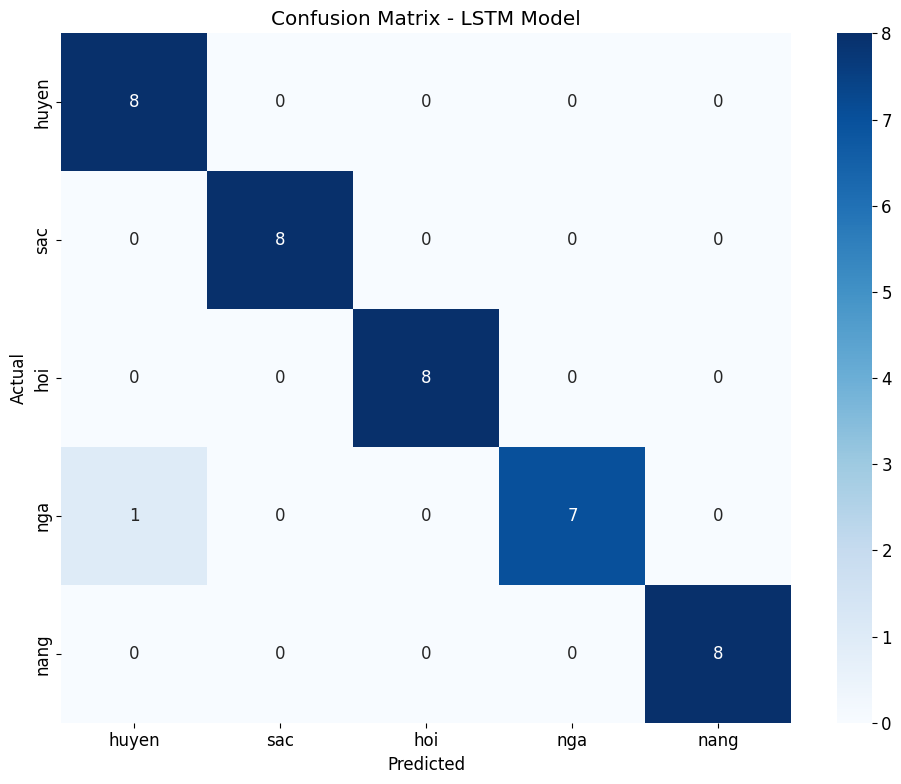

In [22]:
# Đánh giá mô hình LSTM
print("=== ĐÁNH GIÁ MÔ HÌNH LSTM ===")
lstm_test_loss, lstm_test_accuracy = lstm_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {lstm_test_accuracy:.4f}")
print(f"Test Loss: {lstm_test_loss:.4f}")

# Dự đoán
lstm_y_pred = lstm_model.predict(X_test)
lstm_y_pred_classes = np.argmax(lstm_y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, lstm_y_pred_classes, 
                          target_names=[class_names[cls] for cls in classes]))

# Confusion matrix
lstm_cm = confusion_matrix(y_test, lstm_y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=[class_names[cls] for cls in classes],
           yticklabels=[class_names[cls] for cls in classes])
plt.title('Confusion Matrix - LSTM Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## 9. Đánh giá mô hình MLP

=== ĐÁNH GIÁ MÔ HÌNH MLP ===
Test Accuracy: 0.9750
Test Loss: 0.0379


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/stepWARNING:tensorflow:6 out of the last 7 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002148A7DF250> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step

Classification Report:
              precision    recall  f1-score   support

       huyen       0.89      1.00      0.94         8
         sac       1.00      1.00      1.00         8
         hoi       1.00      1.00      1.00         8
         nga       1.00      0.88      0.93         8
        nang       1.00      1.00      1.00         8

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



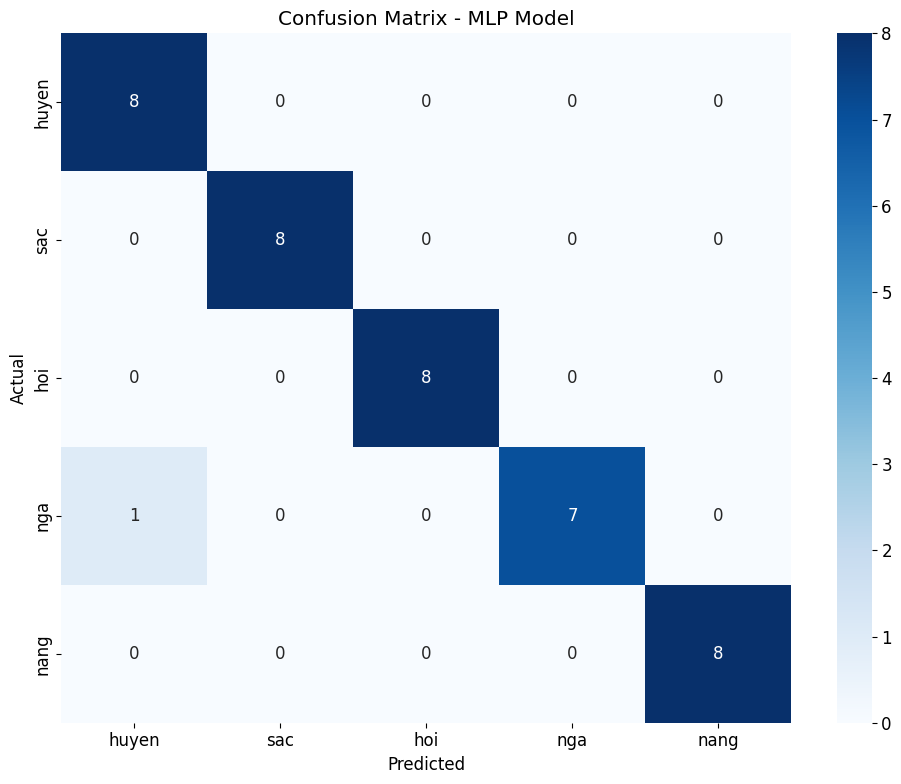

In [23]:
# Đánh giá mô hình MLP
print("=== ĐÁNH GIÁ MÔ HÌNH MLP ===")
mlp_test_loss, mlp_test_accuracy = mlp_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {mlp_test_accuracy:.4f}")
print(f"Test Loss: {mlp_test_loss:.4f}")

# Dự đoán
mlp_y_pred = mlp_model.predict(X_test)
mlp_y_pred_classes = np.argmax(mlp_y_pred, axis=1)

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, mlp_y_pred_classes, 
                          target_names=[class_names[cls] for cls in classes]))

# Confusion matrix
mlp_cm = confusion_matrix(y_test, mlp_y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(mlp_cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=[class_names[cls] for cls in classes],
           yticklabels=[class_names[cls] for cls in classes])
plt.title('Confusion Matrix - MLP Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

## 10. So sánh hiệu suất hai mô hình (LSTM và MLP)

=== SO SÁNH HIỆU SUẤT MÔ HÌNH ===
LSTM Accuracy: 0.9750
MLP Accuracy: 0.9750

🤝 Cả hai mô hình có hiệu suất tương đương!


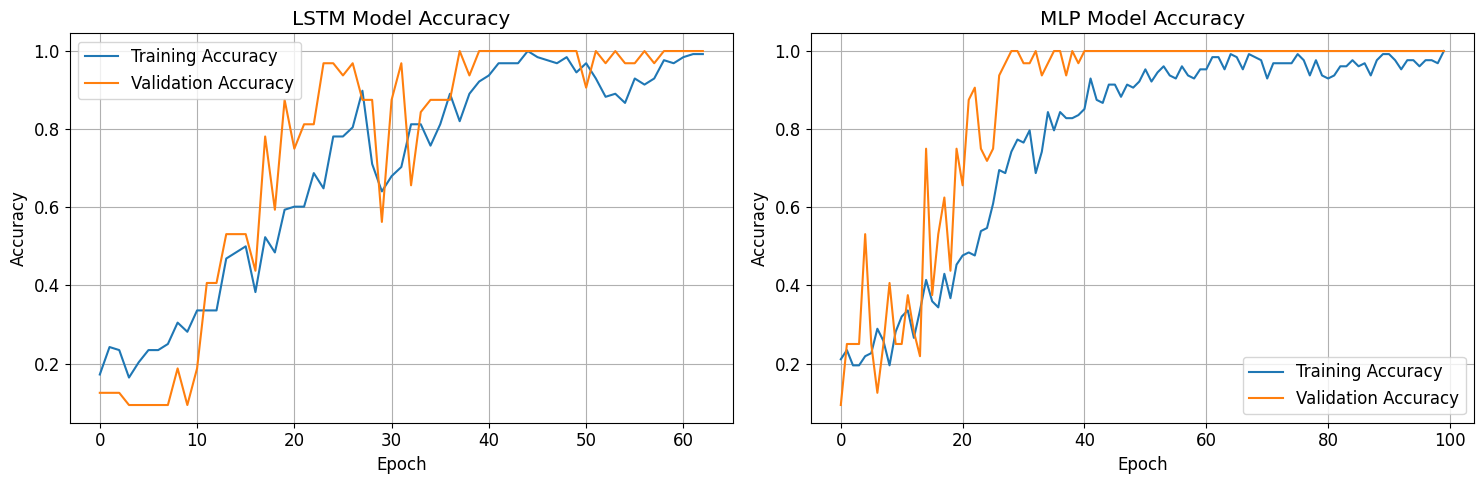

In [24]:
# So sánh hiệu suất
print("=== SO SÁNH HIỆU SUẤT MÔ HÌNH ===")
print(f"LSTM Accuracy: {lstm_test_accuracy:.4f}")
print(f"MLP Accuracy: {mlp_test_accuracy:.4f}")

if lstm_test_accuracy > mlp_test_accuracy:
    print("\n🏆 LSTM hoạt động tốt hơn!")
    best_model = lstm_model
    best_model_name = 'lstm'
elif mlp_test_accuracy > lstm_test_accuracy:
    print("\n🏆 MLP hoạt động tốt hơn!")
    best_model = mlp_model
    best_model_name = 'mlp'
else:
    print("\n🤝 Cả hai mô hình có hiệu suất tương đương!")
    best_model = lstm_model  # Mặc định chọn LSTM
    best_model_name = 'lstm'

# Vẽ biểu đồ so sánh accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# LSTM Training History
ax1.plot(lstm_history.history['accuracy'], label='Training Accuracy')
ax1.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('LSTM Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True)

# MLP Training History
ax2.plot(mlp_history.history['accuracy'], label='Training Accuracy')
ax2.plot(mlp_history.history['val_accuracy'], label='Validation Accuracy')
ax2.set_title('MLP Model Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## 11. Lưu mô hình tốt nhất

In [25]:
# Tạo thư mục trained_models nếu chưa có
os.makedirs('trained_models', exist_ok=True)

# Lưu mô hình tốt nhất
best_model_path = f'trained_models/{best_model_name}_model_final.h5'
best_model.save(best_model_path)

# Lưu label encoder
encoder_path = f'trained_models/{best_model_name}_model_label_encoder.pkl'
data_processor.save_label_encoder(encoder_path)

print(f"\n✅ Mô hình tốt nhất đã được lưu:")
print(f"  - Mô hình: {best_model_path}")
print(f"  - Label encoder: {encoder_path}")
print(f"  - Loại mô hình: {best_model_name.upper()}")
print(f"  - Accuracy: {max(lstm_test_accuracy, mlp_test_accuracy):.4f}")


✅ Mô hình tốt nhất đã được lưu:
  - Mô hình: trained_models/lstm_model_final.h5
  - Label encoder: trained_models/lstm_model_label_encoder.pkl
  - Loại mô hình: LSTM
  - Accuracy: 0.9750


## 12. Tóm tắt kết quả

In [26]:
# Tóm tắt kết quả
print("=== TÓM TẮT KẾT QUẢ HUẤN LUYỆN ===")
print(f"\n📊 Thống kê dữ liệu:")
for cls in classes:
    print(f"  - {class_names[cls]}: {stats[cls]} mẫu")
print(f"  - Tổng cộng: {stats['total']} mẫu")

print(f"\n🤖 Kết quả mô hình:")
print(f"  - LSTM Accuracy: {lstm_test_accuracy:.4f}")
print(f"  - MLP Accuracy: {mlp_test_accuracy:.4f}")
print(f"  - Mô hình tốt nhất: {best_model_name.upper()}")

print(f"\n💾 Mô hình đã được lưu tại:")
print(f"  - {best_model_path}")
print(f"  - {encoder_path}")

print(f"\n🎯 Bước tiếp theo:")
print(f"  - Chạy predict.py để test mô hình")
print(f"  - Hoặc sử dụng mô hình trong ứng dụng thực tế")

=== TÓM TẮT KẾT QUẢ HUẤN LUYỆN ===

📊 Thống kê dữ liệu:
  - huyen: 40 mẫu
  - sac: 40 mẫu
  - hoi: 40 mẫu
  - nga: 40 mẫu
  - nang: 40 mẫu
  - Tổng cộng: 200 mẫu

🤖 Kết quả mô hình:
  - LSTM Accuracy: 0.9750
  - MLP Accuracy: 0.9750
  - Mô hình tốt nhất: LSTM

💾 Mô hình đã được lưu tại:
  - trained_models/lstm_model_final.h5
  - trained_models/lstm_model_label_encoder.pkl

🎯 Bước tiếp theo:
  - Chạy predict.py để test mô hình
  - Hoặc sử dụng mô hình trong ứng dụng thực tế
